# Landscape Classification! 
## We'll use Convolutional Neural Networks to attempt this task.
### Our goal is to accurately classify as many of the images as we can!

In [86]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle                 # randomly shuffles order of images       
import matplotlib.pyplot as plt  
import seaborn as sns
import cv2                                        # can read, alter, and resize images
from tqdm import tqdm                             # creates progress bars for long tasks

## Loading and Cleaning Data:

In [87]:
# These are the six types of images we will classify
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

In [88]:
# We will use cv2 to read the image paths, convert them to RGB form, and resize them consistently

def load_data():
    output = []
    datasets = ["train_data", "test_data"]
    for dataset in datasets:
        images = []
        labels = []
        print(f"Working on {dataset}:")
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA) 
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32') 
    
        output.append((images, labels))

    return output

In [24]:
(init_train_images, init_train_labels), (init_test_images, init_test_labels) = load_data()

Working on train_data:


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:05<00:00, 442.57it/s]


Working on test_data:


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:01<00:00, 416.01it/s]


In [25]:
# We will randomize the order of the train and test data.

train_images, train_labels = shuffle(init_train_images, init_train_labels, random_state=69)
test_images, test_labels = shuffle(init_test_images, init_test_labels, random_state=69)

# For each image, we want to change the range of RGB values from 0-255 to be between 0 and 1, 
# since our neural network will only take values in this range.

train_images = train_images / 255
test_images = test_images / 255

## Let's take a look at some of the cleaned data:
#### (take a close look at the 15th image, just left of the bottom right - hmm...)

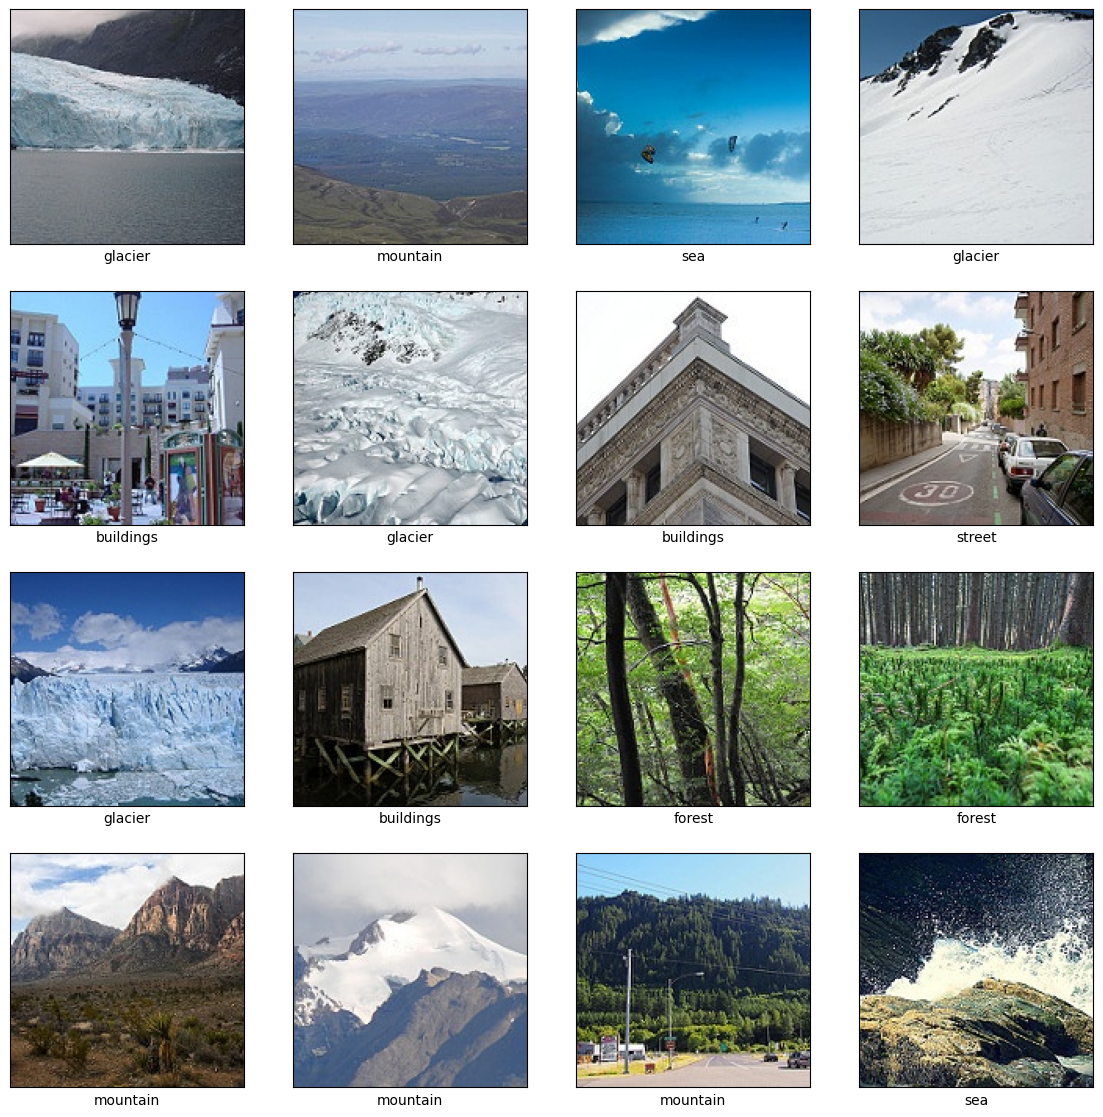

In [27]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(14,14))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

display_examples(class_names, train_images, train_labels)

In [30]:
# We convert each landscape label into dummy columns so we can easily feed the result into the neural network.

train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)

test_labels.head(1)

0      1      2      3     4      5
0  False  False  False  False  True  False

## Model Creation!
### We will use Keras.Conv2D for our CNN.

In [18]:
from keras.models import Sequential, load_model, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input, Dense, Conv2D, Activation, Add, ReLU, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

In [1]:
# train_images[0]

In [31]:
model = Sequential([
    
#   Convolutional Layers create a set of output filters by passing a convolution screen
#   over the entire image with size "kernel_size", with the distance between each collection as "strides"
    Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', input_shape=(150, 150, 3)),     
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),           # picks the max value from each 2x2 square; halves image size
    BatchNormalization(),                  # standardizes outputs before passing them into the next layer

    Conv2D(64, 3, 2, padding='same', kernel_regularizer=l2(0.00005)),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(128, 5, 2, padding='same', kernel_regularizer=l2(0.00005)),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(units=256, activation='relu'),
    Dropout(0.5),
    
    Dense(units=6, activation='softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 activation_7 (Activation)   (None, 38, 38, 64)       

In [32]:

# learning rate reduction ensures the model stops trying to learn too fast once it's reached its peak
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

# we will augment more data, with slight shifts applied, to increase the model's robustness
datagen = ImageDataGenerator(
        rotation_range=15,               # randomly rotate images in the range 
        zoom_range = 0.1,                # Randomly zooms image 
        width_shift_range=0.1,           # randomly shift images horizontally
        height_shift_range=0.1,          # randomly shift images vertically
        horizontal_flip=True)            # randomly flips image horizontally

In [33]:
model.compile(loss=keras.losses.categorical_crossentropy, metrics = ["accuracy"], optimizer = 'adam')
datagen.fit(train_images)

In [34]:
# We will use the test data as our validation set

history = model.fit(datagen.flow(train_images, train_labels, batch_size = 128), epochs = 50, verbose = 1, 
                    validation_data = (test_images, test_labels), callbacks = [learning_rate_reduction])

Epoch 1/50
110/110 [==============================] - 146s 1s/step - loss: 1.1976 - accuracy: 0.6022 - val_loss: 2.4564 - val_accuracy: 0.3617 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 159s 1s/step - loss: 0.7848 - accuracy: 0.7163 - val_loss: 4.3802 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 144s 1s/step - loss: 0.6732 - accuracy: 0.7608 - val_loss: 3.6527 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 152s 1s/step - loss: 0.6239 - accuracy: 0.7822 - val_loss: 2.3432 - val_accuracy: 0.5080 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 158s 1s/step - loss: 0.5751 - accuracy: 0.8012 - val_loss: 1.0989 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 163s 1s/step - loss: 0.5434 - accuracy: 0.8087 - val_loss: 1.1870 - val_accuracy: 0.6760 - lr: 0.0010
Epoch 7/50
110/110 [==============================] - 142s 1s/st

In [35]:
preds = model.predict(test_images)

94/94 [==============================] - 8s 83ms/step


In [36]:
# The model predicts a probability for each of the labels, so we will choose the 
# highest-probability label as its guess!

preds_df = pd.DataFrame(preds).idxmax(axis = 1)
true_df = test_labels.idxmax(axis = 1)
(preds_df.values == true_df.values).sum()/len(test_labels)

0.872

## We reached 87.2% classification accuracy!

### That's a solid result! But can we see what images tripped up the model?

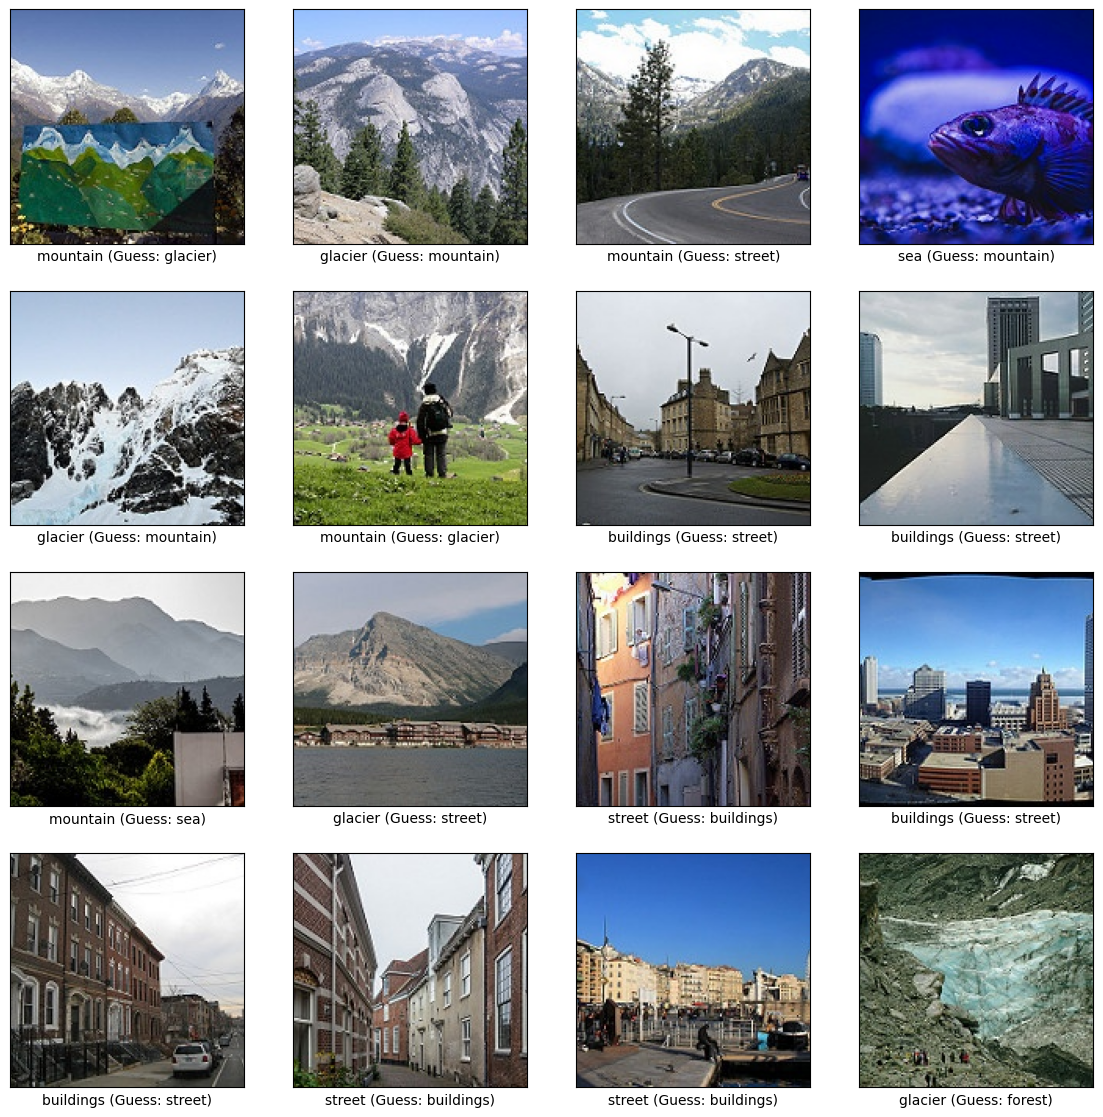

In [45]:
def display_examples(class_names, images, labels, predictions):
    
    fig = plt.figure(figsize=(14,14))
    image_num = 0
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_num += 1
        while labels[image_num] == predictions[image_num] and image_num < len(labels):
            image_num += 1
        plt.imshow(images[image_num], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[image_num]] + " (Guess: {})".format(class_names[predictions[image_num]]))
    plt.show()

display_examples(class_names, test_images, true_df, preds_df)


## Some of those images are very tricky, and some even seem incorrectly labeled - even a human couldn't get 100% on this!

### Let's see what kinds of images the model went wrong on:

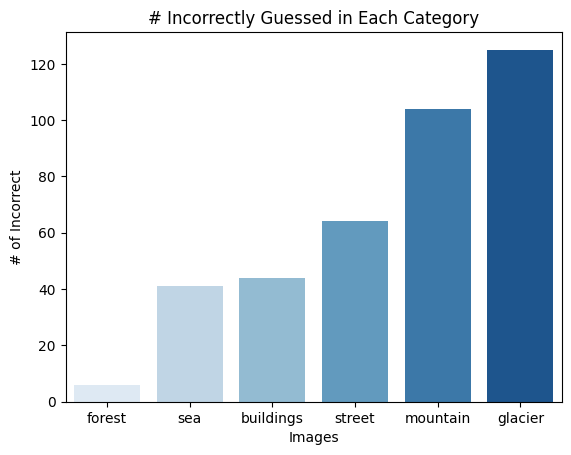

In [62]:
incorrect_by_category = [0] * 6
for (true, pred) in zip(true_df, preds_df):
    if true != pred:
        incorrect_by_category[true] += 1

sns.set_palette('Blues')
sns.barplot(x='Images', y='Counts', data= (pd.DataFrame({'Images': class_names, 'Counts': incorrect_by_category})).sort_values(by = "Counts"))

plt.xlabel('Images')
plt.ylabel('# of Incorrect')
plt.title('# Incorrectly Guessed in Each Category')
plt.show()

### I have a gut feeling that the model might have mistaken glaciers and mountains for each other... let's see!

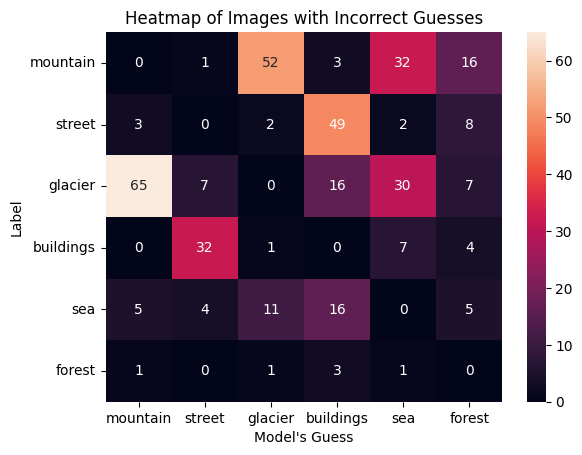

In [83]:
incorrect_breakdown = [[0] * 6 for i in range(6)]
incorrect_breakdown

for (true, pred) in zip(true_df, preds_df):
    if true != pred:
        incorrect_breakdown[true][pred] += 1
        

sns.heatmap(incorrect_breakdown, annot=True, xticklabels = class_names, yticklabels = class_names)
plt.yticks(rotation=0) 
plt.xlabel("Model's Guess")
plt.ylabel("Label")
plt.title("Heatmap of Images with Incorrect Guesses")
plt.show()

## It seems like mountains and glaciers are most often confused with each other, followed by buildings and streets. 

# The End! 

## With a pre-trained model, the accuracy can be boosted up to 94% or higher, but I wanted to try creating my own model for this task.


# I hope you enjoyed this project! 
### The dataset can be found here: https://www.kaggle.com/datasets/puneet6060/intel-image-classification